In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
from glob import glob
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from distance import *
from utils import *

In [3]:
def get_hists(dist, bins=100):
    res = np.zeros(bins)
    for filename in glob("data/poland_warszawa_2023_*.pb"):
        print(filename)
        X = load_pb_ohe(filename)[2]
        hist, bin_edges = np.histogram(
            dist(X),
            bins=bins,
            range=(0,1),
        )
        assert res.shape == hist.shape
        res += hist / hist.sum()
    return res

In [4]:
print(f"{"rodzaj":40}, {"liczba projektów":16}, {"liczba głosów":13}")
for filename in glob("data/poland_warszawa_2023*.pb"):
    meta = load_pb(filename)[0]
    print(f"{meta['description']:40}, {meta['num_projects']:16}, {meta['num_votes']:13}")

rodzaj                                  , liczba projektów, liczba głosów
District PB in Warsaw, Bemowo           ,               83,          5180
District PB in Warsaw, Białołęka        ,               72,          9173
District PB in Warsaw, Bielany          ,               98,          4956
District PB in Warsaw, Mokotów          ,               81,         11067
District PB in Warsaw, Ochota           ,               81,          4392
District PB in Warsaw, Praga-Północ     ,               91,          2818
District PB in Warsaw, Praga-Południe   ,               81,          8922
District PB in Warsaw, Rembertów        ,               38,          1172
District PB in Warsaw, Śródmieście      ,               47,          3883
District PB in Warsaw, Targówek         ,               97,          4680
District PB in Warsaw, Ursus            ,               72,          4519
District PB in Warsaw, Ursynów          ,               64,          6260
District PB in Warsaw, Wawer          

In [5]:
def sample_jaccard(X, size):
    xs = X[np.random.choice(X.shape[0], size=size)]
    ys = X[np.random.choice(X.shape[0], size=size)]
    return 1 - np.minimum(xs, ys).sum(axis=-1) / np.maximum(xs, ys).sum(axis=-1)
def sample_cosine(X, size):
    xs = normalize(X[np.random.choice(X.shape[0], size=size)], norm='l2', axis=1)
    ys = normalize(X[np.random.choice(X.shape[0], size=size)], norm='l2', axis=1)
    return 1 - (xs * ys).sum(axis=-1)
def sample_chord(X, size):
    xs = normalize(X[np.random.choice(X.shape[0], size=size)], norm='l2', axis=1)
    ys = normalize(X[np.random.choice(X.shape[0], size=size)], norm='l2', axis=1)
    return np.linalg.norm(xs-ys, axis=-1) / np.sqrt(2)
def sample_all(X, size):
    return np.array([sample_jaccard(X, size), sample_cosine(X, size), sample_chord(X, size)])

In [6]:
districts = [
    "bemowo",
    "bialoleka",
    "bielany",
    "mokotow",
    "ochota",
    "praga-polnoc",
    "praga-poludnie",
    "rembertow",
    "srodmiescie",
    "targowek",
    "ursus",
    "ursynow",
    "wawer",
    "wesola",
    "wilanow",
    "wlochy",
    "wola",
    "zoliborz",
]
filenames = [
    f"data/poland_warszawa_2023_{district}.pb"
    for district in districts
]

In [7]:
sample_size = 1000000
distances = np.array([
    sample_all(load_pb_ohe(filename)[2], sample_size)
    for filename in filenames
])

KeyboardInterrupt: 

Text(0.5, 1.0, 'Chord')

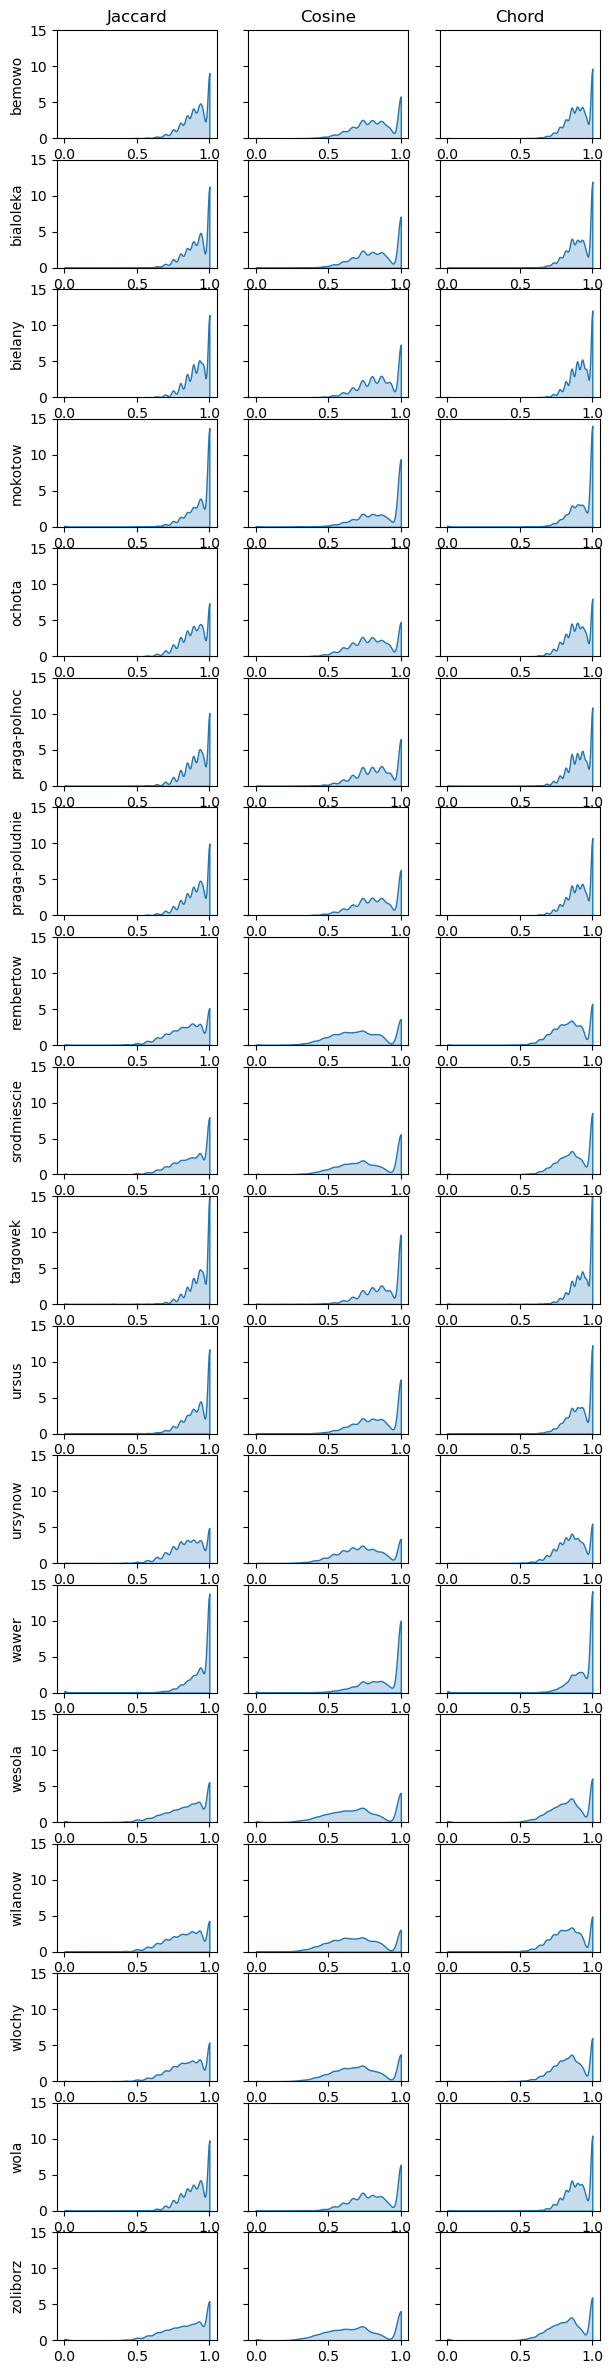

In [8]:
rows = distances.shape[0]
cols = distances.shape[1]
fig, axs = plt.subplots(
    nrows=rows,
    ncols=cols,
    sharey='row',
    figsize=(7,30),
)
for i, (dists, district) in enumerate(zip(distances, districts)):
    for j, dist in enumerate(dists):
        sns.kdeplot(
            dist,
            fill=True,
            clip=(0,1),
            bw_adjust=2,
            ax=axs[i,j],
        )
        axs[i,j].set_ylim(0, 15)
        axs[i,j].set_ylabel(district)
axs[0,0].set_title("Jaccard")
axs[0,1].set_title("Cosine")
axs[0,2].set_title("Chord")

In [3]:
meta, projects, votes = load_pb_ohe('data/poland_warszawa_2023_srodmiescie.pb')
votesT = votes.T

In [9]:
d_v_jaccard = jaccard(votes, votes)
d_v_cosine = cosine(votes, votes)
d_v_chord = chord(votes, votes) / np.sqrt(2)
d_v_simrank_60, d_p_simrank_60 = simrank_both(votes, 0.6, 0.6, max_iter=1000)
d_v_simrank_80, d_p_simrank_80 = simrank_both(votes, 0.8, 0.8, max_iter=1000)
d_v_simrank_95, d_p_simrank_95 = simrank_both(votes, 0.95, 0.95, max_iter=1000)
d_v_simrank_99, d_p_simrank_99 = simrank_both(votes, 0.99, 0.99, max_iter=1000)
d_p_jaccard = jaccard(votesT, votesT)
d_p_cosine = cosine(votesT, votesT)
d_p_chord = chord(votesT, votesT) / np.sqrt(2)

Iteration 0 norm is (np.float64(168.60927724981624), np.float64(0.010080729068083678))
Iteration 1 norm is (np.float64(0.43902754407794026), np.float64(0.43339357795909705))
Iteration 2 norm is (np.float64(21.64402908511463), np.float64(0.003294645062908632))
Iteration 3 norm is (np.float64(0.15775081081418732), np.float64(0.15732736028957955))
Iteration 4 norm is (np.float64(7.64436358786751), np.float64(0.0011542528255285955))
Iteration 5 norm is (np.float64(0.05586712002931711), np.float64(0.05546526510735629))
Iteration 6 norm is (np.float64(2.694171792014923), np.float64(0.00040430041375761483))
Iteration 7 norm is (np.float64(0.019643440373860725), np.float64(0.01944428442883393))
Iteration 8 norm is (np.float64(0.9457868947016952), np.float64(0.0001415834710153348))
Iteration 9 norm is (np.float64(0.0068892564699685865), np.float64(0.0068100549818670975))
Iteration 10 norm is (np.float64(0.3315037824226026), np.float64(4.9577903766092566e-05))
Iteration 11 norm is (np.float64(0.

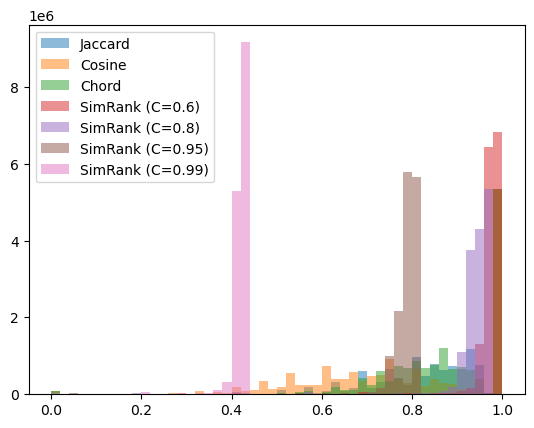

In [11]:
args = {"bins": 50, "alpha": 0.5, "range": (0, 1)}
plt.hist(d_v_jaccard.reshape(-1), label="Jaccard", **args)
plt.hist(d_v_cosine.reshape(-1), label="Cosine", **args)
plt.hist(d_v_chord.reshape(-1), label="Chord", **args)
plt.hist(d_v_simrank_60.reshape(-1), label="SimRank (C=0.6)", **args)
plt.hist(d_v_simrank_80.reshape(-1), label="SimRank (C=0.8)", **args)
plt.hist(d_v_simrank_95.reshape(-1), label="SimRank (C=0.95)", **args)
plt.hist(d_v_simrank_99.reshape(-1), label="SimRank (C=0.99)", **args)
plt.legend()
plt.show()

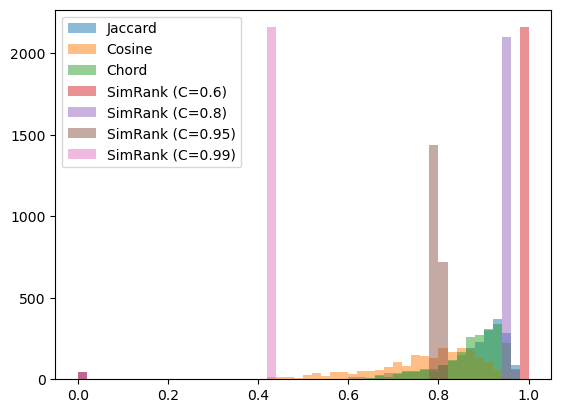

In [12]:
args = {"bins": 50, "alpha": 0.5, "range": (0, 1)}
plt.hist(d_p_jaccard.reshape(-1), label="Jaccard", **args)
plt.hist(d_p_cosine.reshape(-1), label="Cosine", **args)
plt.hist(d_p_chord.reshape(-1), label="Chord", **args)
plt.hist(d_p_simrank_60.reshape(-1), label="SimRank (C=0.6)", **args)
plt.hist(d_p_simrank_80.reshape(-1), label="SimRank (C=0.8)", **args)
plt.hist(d_p_simrank_95.reshape(-1), label="SimRank (C=0.95)", **args)
plt.hist(d_p_simrank_99.reshape(-1), label="SimRank (C=0.99)", **args)
plt.legend()
plt.show()

In [13]:
corr = pd.DataFrame({
    "Jaccard": d_v_jaccard.reshape(-1),
    "Cosine": d_v_cosine.reshape(-1),
    "Chord": d_v_chord.reshape(-1),
    "Simrank (C=0.8)": d_v_simrank_80.reshape(-1),
}).corr()
corr

,Jaccard,Cosine,Chord,Simrank (C=0.8)
Jaccard,1.000000,0.957265,0.984056,0.636020
Cosine,0.957265,1.000000,0.971437,0.565068
Chord,0.984056,0.971437,1.000000,0.700808
Simrank (C=0.8),0.636020,0.565068,0.700808,1.000000


In [14]:
def jaccard_matrix(X):
    return np.array([
        [1 - len(x1.intersection(x2)) / len(x1.union(x2)) for x2 in X]
        for x1 in X
    ])

In [15]:
corr = pd.DataFrame({
    "Jaccard": d_p_jaccard.reshape(-1),
    "Cosine": d_p_cosine.reshape(-1),
    "Chord": d_p_chord.reshape(-1),
    "Simrank (C=0.8)": d_p_simrank_80.reshape(-1),
    "Category Jaccard": jaccard_matrix(projects['category']).reshape(-1),
    "Target Jaccard": jaccard_matrix(projects['target']).reshape(-1),
}).corr()
corr

,Jaccard,Cosine,Chord,Simrank (C=0.8),Category Jaccard,Target Jaccard
Jaccard,1.000000,0.965753,0.995254,0.848070,0.461900,0.192888
Cosine,0.965753,1.000000,0.954023,0.700651,0.464673,0.205142
Chord,0.995254,0.954023,1.000000,0.881124,0.454931,0.197283
Simrank (C=0.8),0.848070,0.700651,0.881124,1.000000,0.347725,0.140749
Category Jaccard,0.461900,0.464673,0.454931,0.347725,1.000000,0.232611
Target Jaccard,0.192888,0.205142,0.197283,0.140749,0.232611,1.000000
